In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

In [2]:
# Load HW Acc.
device = torch.device("mps")

In [3]:
## 配置其他超参数，如batch_size, num_workers, learning rate, 以及总的epochs
batch_size = 256
num_workers = 7   # 对于Windows用户，这里应设置为0，否则会出现多线程错误
lr = 1e-4
epochs = 20

In [4]:
from torchvision import transforms

image_size = 28
data_transform = transforms.Compose([
    # transforms.ToPILImage(),  
    # 这一步取决于后续的数据读取方式，如果使用内置数据集读取方式则不需要
    transforms.Resize(image_size),
    transforms.ToTensor()
])

In [5]:
# Load DataSet
from torchvision import datasets

train_data = datasets.FashionMNIST(root='../dataset/FashionMNIST', train=True, download=True, transform=data_transform)
test_data = datasets.FashionMNIST(root='../dataset/FashionMNIST', train=False, download=True, transform=data_transform)

In [6]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

torch.Size([256, 1, 28, 28]) torch.Size([256])


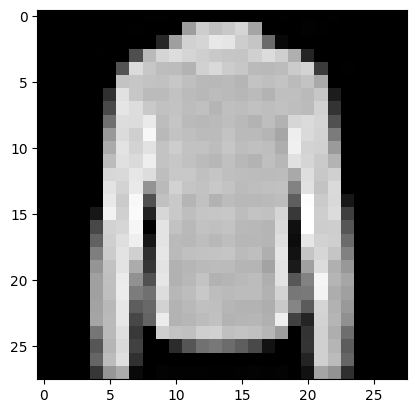

In [7]:
import matplotlib.pyplot as plt
image, label = next(iter(train_loader))
print(image.shape, label.shape)
plt.imshow(image[0][0], cmap="gray")

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3)
        )
        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*4*4)
        x = self.fc(x)
        # x = nn.functional.normalize(x)
        return x

model = Net()
model = model.to(device=device)

In [9]:
criterion = nn.CrossEntropyLoss()

In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
def train(epoch):
    model.train()
    train_loss = 0
    for data, label in train_loader:
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

In [15]:
def val(epoch):       
    model.eval()
    val_loss = 0
    gt_labels = []
    pred_labels = []
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            preds = torch.argmax(output, 1)
            gt_labels.append(label.cpu().data.numpy())
            pred_labels.append(preds.cpu().data.numpy())
            loss = criterion(output, label)
            val_loss += loss.item()*data.size(0)
    val_loss = val_loss/len(test_loader.dataset)
    gt_labels, pred_labels = np.concatenate(gt_labels), np.concatenate(pred_labels)
    acc = np.sum(gt_labels==pred_labels)/len(pred_labels)
    print('Epoch: {} \tValidation Loss: {:.6f}, Accuracy: {:6f}'.format(epoch, val_loss, acc))

In [16]:
for epoch in range(1, epochs+1):
    train(epoch)
    val(epoch)

Epoch: 1 	Training Loss: 0.655923
Epoch: 1 	Validation Loss: 0.446687, Accuracy: 0.831600
Epoch: 2 	Training Loss: 0.418289
Epoch: 2 	Validation Loss: 0.387068, Accuracy: 0.861000
Epoch: 3 	Training Loss: 0.359369
Epoch: 3 	Validation Loss: 0.346420, Accuracy: 0.871600
Epoch: 4 	Training Loss: 0.325504
Epoch: 4 	Validation Loss: 0.310112, Accuracy: 0.889400
Epoch: 5 	Training Loss: 0.306328
Epoch: 5 	Validation Loss: 0.289475, Accuracy: 0.894500
Epoch: 6 	Training Loss: 0.287859
Epoch: 6 	Validation Loss: 0.280332, Accuracy: 0.897700
Epoch: 7 	Training Loss: 0.274955
Epoch: 7 	Validation Loss: 0.268887, Accuracy: 0.902100
Epoch: 8 	Training Loss: 0.262184
Epoch: 8 	Validation Loss: 0.259565, Accuracy: 0.902400
Epoch: 9 	Training Loss: 0.251910
Epoch: 9 	Validation Loss: 0.257168, Accuracy: 0.903700
Epoch: 10 	Training Loss: 0.239271
Epoch: 10 	Validation Loss: 0.246312, Accuracy: 0.909200
Epoch: 11 	Training Loss: 0.232452
Epoch: 11 	Validation Loss: 0.260038, Accuracy: 0.904800
Epoch: